## Convolutional Neural Network for Image Recognition
- 用CNN判斷人像是否有正確配戴口罩

In [2]:
from PIL import Image
import numpy as np
import os
import pandas as pd
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

In [3]:
dirPath = r'D:\Users\user\Desktop\碩班課程\深度學習\DL HW1\Q2\images'
result = [f for f in os.listdir(dirPath) if os.path.isfile(os.path.join(dirPath, f))]

In [4]:
traindata=pd.read_csv(r'D:\Users\user\Desktop\碩班課程\深度學習\DL HW1\Q2\train.csv')
testdata=pd.read_csv(r'D:\Users\user\Desktop\碩班課程\深度學習\DL HW1\Q2\test.csv')

In [5]:
train_data=[]
for i in range(len(traindata)):
    img=mpimg.imread(r'D:\Users\user\Desktop\碩班課程\深度學習\DL HW1\Q2\images\%s'%traindata['filename'][i])
    I=Image.fromarray(img[traindata['ymin'][i]:traindata['ymax'][i],traindata['xmin'][i]:traindata['xmax'][i]],'RGB')
    I=I.resize((32,32))
    train_data.append(np.asarray(I))

In [6]:
train_label=traindata['label'].map({'good':2,'bad':1,'none':0})

In [17]:
test_data=[]
for i in range(len(testdata)):
    img=mpimg.imread(r'D:\Users\user\Desktop\碩班課程\深度學習\DL HW1\Q2\images\%s'%testdata['filename'][i])
    I=Image.fromarray(img[testdata['ymin'][i]:testdata['ymax'][i],testdata['xmin'][i]:testdata['xmax'][i]],'RGB')
    I=I.resize((32,32))
    test_data.append(np.asarray(I))

In [7]:
test_label=testdata['label'].map({'good':2,'bad':1,'none':0})

In [8]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [9]:
#train data preprocess

preprocess = transforms.Compose([
    transforms.ToTensor(),
    normalize = transforms.Normalize(
    mean=[0.5,0.5,0.5],
    std=[0.5,0.5,0.5]
)
])

train = []
for i in range(len(train_data)):
    train.append([preprocess(train_data[i]), torch.tensor(train_label[i])])

trainloader = torch.utils.data.DataLoader(train, batch_size=32, num_workers=1, shuffle=True)

In [10]:
#test data preprocess

preprocess = transforms.Compose([
    transforms.ToTensor(), # range 0~255 -> 0~1
    normalize = transforms.Normalize(
    mean=[0.5,0.5,0.5],
    std=[0.5,0.5,0.5]
)
])

test = []
for i in range(len(test_data)):
    test.append([preprocess(test_data[i]), torch.tensor(test_label[i])])

testloader = torch.utils.data.DataLoader(test, batch_size=32, num_workers=1, shuffle=False)

In [12]:
#create CNN

kernel_size = 5
stride = 1
padding = 1

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        #output_shape = floor[(image_shape-filter_shape+2*padding)/stride] + 1
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=kernel_size, stride=stride, padding=padding) #30
        self.pool1 = nn.MaxPool2d(2, 2) #15
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=kernel_size, stride=stride, padding=padding) #13
        self.fc1 = nn.Linear(6*6*12, 128) #6
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 3)
        
    def forward(self, input):
        output = self.pool1(F.relu(self.conv1(input)))
        output = self.pool1(F.relu(self.conv2(output)))
#         print(output.shape)
        output = output.view(-1,6*6*12)
#         output = F.dropout(output, p=0.3)
        output = F.relu(self.fc1(output))
        output = F.relu(self.fc2(output))
        output = self.fc3(output)

        return output

net=Net()

In [13]:
min(traindata['label'].value_counts())/traindata['label'].value_counts(),(2,1,0)

(good    0.036543
 bad     0.179931
 none    1.000000
 Name: label, dtype: float64, (2, 1, 0))

In [14]:
weight = torch.tensor([1, 0.179931, 0.036543])

In [15]:
criteria = nn.CrossEntropyLoss(weight=weight)
optimizer = optim.SGD(net.parameters(), lr=0.005, momentum=0.9)

In [16]:
#train model

training_loss=[]
training_acc=[]
testing_acc=[]

epochs=range(32)
net.train()
for epoch in epochs:
    
    train_total=0
    train_correct=0
    test_total=0
    test_correct=0
    running_loss=0
    
    for i,data in enumerate(trainloader, 0):
        print(i)
        inputs, labels = data

        optimizer.zero_grad()
        outputs = net(inputs)
        
        #get training accuracy
        _, pred = torch.max(outputs.data,1)
        train_total+=labels.size(0)
        train_correct += (pred==labels).sum().item()
        
        #get training loss
        loss = criteria(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()   
        
    training_acc.append(train_correct/train_total)
    training_loss.append(running_loss/i+1)
    print('epoch : %s  , training loss : %s'%(epoch, running_loss/i+1))
    print('train acc : %s'%(train_correct/train_total))
    
    # get testing accuracy
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net(images)
            _, pred = torch.max(outputs.data,1)
            test_total+=labels.size(0)
            test_correct += (pred==labels).sum().item()

    testing_acc.append(test_correct/test_total)
    print('test acc : %s'%(test_correct/test_total))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
epoch : 0  , training loss : 2.05521587675268
train acc : 0.7945011337868481


ZeroDivisionError: division by zero

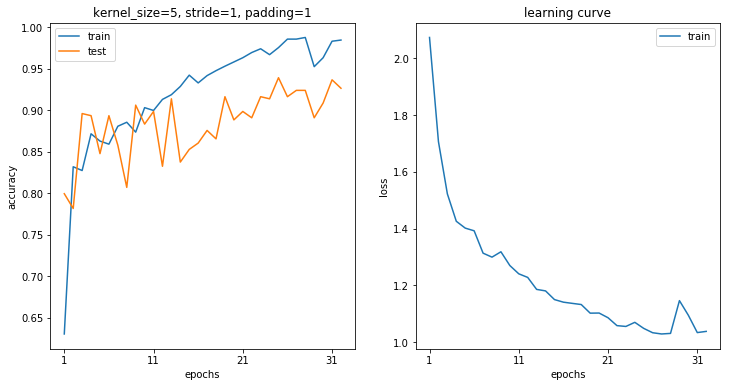

In [211]:
plt.figure(figsize = (12,6))
plt.subplot(1,2,1)
plt.xlabel('epochs'); plt.ylabel('accuracy')
plt.title('kernel_size=%s, stride=%s, padding=%s'%(kernel_size,stride,padding));
plt.plot(range(1,33),training_acc,label='train')
plt.plot(range(1,33),testing_acc,label='test')
plt.xticks(np.arange(1,33,10))
plt.legend()

plt.subplot(1,2,2)
plt.xlabel('epochs'); plt.ylabel('loss')
plt.title('learning curve');
plt.plot(range(1,33,1),training_loss,label='train')
plt.xticks(np.arange(1,33,10))
plt.legend()

In [212]:
correct=0
total=0
net.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, pred = torch.max(outputs.data,1)
        total+=labels.size(0)
        correct += (pred==labels).sum().item()
        
print('Accuracy:%s %%'%(correct/total*100))

Accuracy:92.63959390862944 %


In [213]:
class_correct=list(0 for i in range(3))
class_total=list(0 for i in range(3))
net.eval()
with torch.no_grad():
    for data in trainloader:
        images, labels = data
        outputs = net(images)
        _, pred = torch.max(outputs.data,1)
        c=(pred==labels).squeeze()
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label]+=c[i].item()
            class_total[label]+=1
            
mapping={2:'good',1:'bad',0:'none'}
            
for i in range(3):
    print('train accuracy of %s : %s,  total sample of %s : %s'%(mapping[i],class_correct[i]/class_total[i],mapping[i],class_total[i]))    

print('\r')    
    
class_correct=list(0 for i in range(3))
class_total=list(0 for i in range(3))
net.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, pred = torch.max(outputs.data,1)
        c=(pred==labels).squeeze()
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label]+=c[i].item()
            class_total[label]+=1
            
mapping={2:'good',1:'bad',0:'none'}
            
for i in range(3):
    print('test accuracy of %s : %s,  total sample of %s : %s'%(mapping[i],class_correct[i]/class_total[i],mapping[i],class_total[i]))    
    

train accuracy of none : 1.0,  total sample of none : 104
train accuracy of bad : 1.0,  total sample of bad : 578
train accuracy of good : 0.983134223471539,  total sample of good : 2846

test accuracy of none : 0.7727272727272727,  total sample of none : 22
test accuracy of bad : 0.9101123595505618,  total sample of bad : 89
test accuracy of good : 0.9434628975265018,  total sample of good : 283


In [270]:
#examples of classification result

imgraw=mpimg.imread(r'C:\Users\danie\OneDrive\桌面\DL HW1\Q2\images\20200120000931.jpg')
img=imgraw.copy()

pred_label=[]
for data in testloader:
    images, labels = data
    pred_label.append(labels)
pred_label=pred_label[0].numpy()[14:18]
subtest=testdata.iloc[14:18,:].reset_index(drop=True)

for i in range(len(subtest)):
    if(pred_label[i]==2):
        for rgb in range(3):
            if(rgb==1):
                img[subtest['ymin'][i]:subtest['ymin'][i]+3,subtest['xmin'][i]:subtest['xmax'][i],rgb]=255
                img[subtest['ymax'][i]:subtest['ymax'][i]+3,subtest['xmin'][i]:subtest['xmax'][i],rgb]=255
                img[subtest['ymin'][i]:subtest['ymax'][i],subtest['xmin'][i]:subtest['xmin'][i]+3,rgb]=255
                img[subtest['ymin'][i]:subtest['ymax'][i],subtest['xmax'][i]:subtest['xmax'][i]+3,rgb]=255
            else:
                img[subtest['ymin'][i]:subtest['ymin'][i]+3,subtest['xmin'][i]:subtest['xmax'][i],rgb]=0
                img[subtest['ymax'][i]:subtest['ymax'][i]+3,subtest['xmin'][i]:subtest['xmax'][i],rgb]=0
                img[subtest['ymin'][i]:subtest['ymax'][i],subtest['xmin'][i]:subtest['xmin'][i]+3,rgb]=0
                img[subtest['ymin'][i]:subtest['ymax'][i],subtest['xmax'][i]:subtest['xmax'][i]+3,rgb]=0
    else:
        for rgb in range(3):
            if(rgb==0):
                img[subtest['ymin'][i]:subtest['ymin'][i]+3,subtest['xmin'][i]:subtest['xmax'][i],rgb]=255
                img[subtest['ymax'][i]:subtest['ymax'][i]+3,subtest['xmin'][i]:subtest['xmax'][i],rgb]=255
                img[subtest['ymin'][i]:subtest['ymax'][i],subtest['xmin'][i]:subtest['xmin'][i]+3,rgb]=255
                img[subtest['ymin'][i]:subtest['ymax'][i],subtest['xmax'][i]:subtest['xmax'][i]+3,rgb]=255
            else:
                img[subtest['ymin'][i]:subtest['ymin'][i]+3,subtest['xmin'][i]:subtest['xmax'][i],rgb]=0
                img[subtest['ymax'][i]:subtest['ymax'][i]+3,subtest['xmin'][i]:subtest['xmax'][i],rgb]=0
                img[subtest['ymin'][i]:subtest['ymax'][i],subtest['xmin'][i]:subtest['xmin'][i]+3,rgb]=0
                img[subtest['ymin'][i]:subtest['ymax'][i],subtest['xmax'][i]:subtest['xmax'][i]+3,rgb]=0

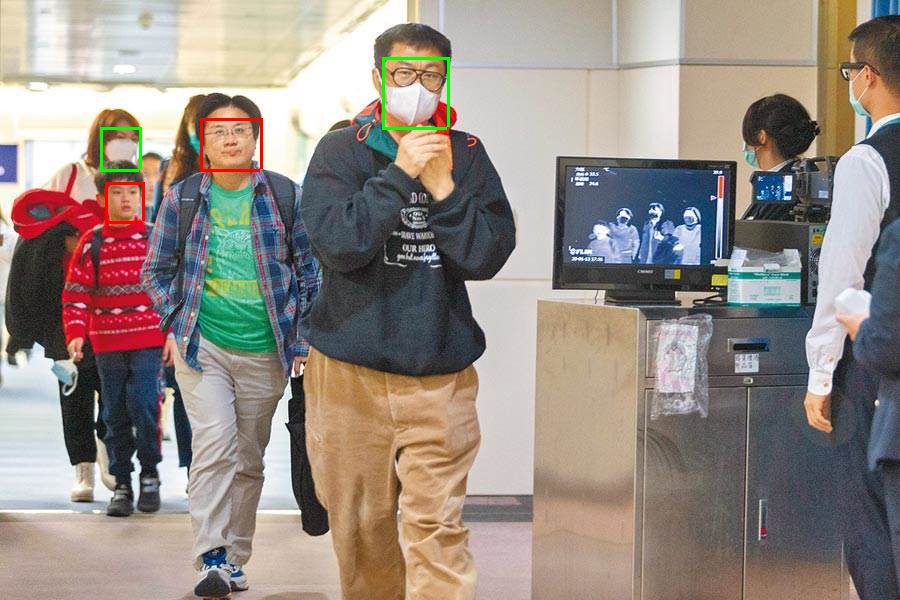

In [271]:
Image.fromarray(img)